# LINCS Publications & Citations Report

*Created by Brian M. Schilder, Moshe Silverstein, and Alexandra Keenan on 09/22/2018.*

In [278]:
%matplotlib inline

import sys
print (sys.version)
# token: 428145730f2d00b0596bd2521918df095fc272a23500acb4
import os
os.getcwd()
os.chdir('../LINCS-Publications-Report')

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary
- Plots:
	- Publications over time
	- Citations over time


- Repeat these plots for each of the following groupings:
	- Aggregated across internal LINCS centers

	- Divided amongst internal LINCS centers (label by center, not PI)
		1. Data Coordination and Integration Center (Mount Sinai, Avi Ma’ayan)
		2. Drug Toxicity Signature Generation Center (Mount Sinai, Ravi Iyengar)
		3. LINCS Proteomic Characterization Center for Signaling and Epigenetics (Broad Institute, Jacob Jaffe)
		4. Microenvironment Perturbagen (MEP) LINCS Center (Oregon Health & Science University, Joe Gray)
		5.	HMS LINCS Center (Peter Sorger)
		6.	LINCS Center for Transcriptomics (Broad Institute, Todd Golub)
		7.	NeuroLINCS Center  (UC-Irvine, Leslie Thompson)
	- Across all groups external to LINCS (E.g. papers that used L1000, Canvas Browser).; 

### Import Data

In [279]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sn.set_style('whitegrid')
sn.set(font_scale=1.5) 
# Author info from LINCS database (collected 
authors = pd.read_table('authors.tsv')
authors.rename(columns={'id':'author_id'}, inplace=True)

authors_pubs = pd.read_table('authors_publications.tsv')
authorKey = authors.merge(authors_pubs, on='author_id')


# Publications (internal and external to the LINCS centers)
# Collected by Moshe Silverstein
## had to manually correct a couple errors in file
pubs = pd.read_table('publications.tsv') 
# Fill missing pub ids
maxID = int(max(pubs['id']))
fillerIDs = pd.Series(range(maxID, maxID+sum(pd.isnull(pubs['id'])) ))
pubs.fillna(fillerIDs, inplace=True)
# Rename cols
pubs.rename(columns={'id':'publication_id'}, inplace=True)  
# pubs['publication_id'] = pubs['publication_id'].astype(int)

# Get authors and concatenate
pubs_tmp = pubs.merge(authorKey, on='publication_id')
authorsConcat = pubs_tmp.groupby('publication_id')['name'].apply(lambda x: "%s" % ', '.join(x)).reset_index()
authorsConcat.rename(columns={'name':'authors'}, inplace=True) 
pubs = pubs.merge(authorsConcat, on='publication_id').drop_duplicates()  
pubs.columns
# Additional publications (internal and external to the LINCS centers)
#  collected by Alexandra Keenan
pubs2 = pd.read_csv('additional_pubs.csv')

def externalInternal(val):
    if val == 'outside':
        return 0
    else:
        return 1
pubs2['center_pub'] = pubs2['center'].apply(externalInternal)
pubs2 = pubs2.rename(columns={'PMID':'pm_id', 'year':'year_published', 'title':'article_name'})
pubs2['publication_id'] = max(pubs['publication_id'].astype(int)) 



# Add together all pubs
pubs_extended = pd.concat([pubs, pubs2],axis=0,  ignore_index=True)
# Fix pmc_id and pm_id
pubs_extended['pm_id'] =pubs_extended['pm_id'].fillna(0).astype(int)


### Get additional publications by searching grant numbers in PubMed API

In [282]:
import pandas as pd
grantIDs = pd.read_csv('LINCS_centers_by_grant.csv')

pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'+'db=pubmed&term='
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu'  
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08' 
urls = pubmed_url+grantIDs['grant'] +'[Grant+Number]'+'&datetype=edat&retmax=1000&usehistory=y'+\
       '&tool='+tool+'&email='+\
       email+'&api_key='+APIkey
url=urls[1]

from requests import get
import xmltodict   
import time 
def grants_to_pubs(url): 
    grant = url.split('&term=')[1].split("[Grant+Number]")[0] 
    response = get(str(url))
    resultsDict = xmltodict.parse(response.content)
    try:
        pmids = resultsDict['eSearchResult']['IdList']['Id']
        status = str(len(set(pmids)))+' publications found' 
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        pmids = []
        status = 'None found'
    print("Extracting Citations for grant : "+grant+"........ "+status)
    return pmids

res = map(grants_to_pubs, urls)
results = list(res) 


grantPubs_PMIDs=[]
for lst in results:
    grantPubs_PMIDs += lst

print('\n*********\n'+str(len(set(grantPubs_PMIDs))) +" unique publications found through grant PubMed API searches." )

    
grantPubs = dict(zip(grantIDs['grant'], results)) 


Extracting Citations for grant : U54-HG008097........ 10 publications found


Extracting Citations for grant : U54-HG008100........ 17 publications found
Extracting Citations for grant : U54-HG008230........ None found


Extracting Citations for grant : U54-HL127624........ 73 publications found


Extracting Citations for grant : U54-HG008098........ 12 publications found


Extracting Citations for grant : U54-HL127365........ 36 publications found


Extracting Citations for grant : U54-HG006097........ 66 publications found


Extracting Citations for grant : U54-HL127366........ 6 publications found


Extracting Citations for grant : U54-HG006093........ 12 publications found


Extracting Citations for grant : U54-NS091046........ 23 publications found
Extracting Citations for grant : U54HG008097........ None found


Extracting Citations for grant : U54HG008100........ 4 publications found


Extracting Citations for grant : U54HG008230........ 5 publications found


Extracting Citations for grant : U54HL127624........ 8 publications found


Extracting Citations for grant : U54HG008098........ 2 publications found


Extracting Citations for grant : U54HL127365........ 2 publications found


Extracting Citations for grant : U54HG006097........ 14 publications found
Extracting Citations for grant : U54HL127366........ None found


Extracting Citations for grant : U54HG006093........ 2 publications found


Extracting Citations for grant : U54NS091046........ 6 publications found

*********
243 unique publications found through grant PubMed API searches.


### Add any new PMIDs to current list

In [283]:
# Add new PMIDs from pubmed grants search that aren't already included 
previousPMIDs = pubs_extended['pm_id'].fillna(0).astype(int)
previousPMIDs = previousPMIDs[previousPMIDs!=0].astype(str)
newPMIDs = set(grantPubs_PMIDs) - set(previousPMIDs)
print('PubMed grant search found '+str(len(newPMIDs))+' additional internal LINCS publications.')
newPMIDs_df = pd.DataFrame(pd.Series(list(newPMIDs), name='pm_id')) 

pubs_extended = pubs_extended.merge(newPMIDs_df, on='pm_id', how='outer')
## Assign 1 (internal) to new pubs pulled from grants 
pubs_extended.loc[ pubs_extended['pm_id'].isin( list(newPMIDs) ),'center_pub'] = 1

pubs_extended['pm_id'] = pubs_extended['pm_id'].astype(int) 
# pubs_extended.head()

PubMed grant search found 133 additional internal LINCS publications.


### Convert PMIDS to PMCs

In [284]:
converter_url =  'https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?'+\
                 'ids=' 
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMID_list = pubs_extended['pm_id'] 
PMID_list = PMID_list[PMID_list!=0].astype(str)

urls = converter_url+PMID_list +'&tool='+tool+'&email='+email+'&api_key='+APIkey+'&retmode=json'
url=urls[0]

import xmltodict, time
from requests import get
def PMID_to_PMCID(url): 
    PMID = url.split('ids=')[1].split("&tool")[0] 
    response = get(str(url))
    pmDict = xmltodict.parse(response.content)
    try:
        PMCid = status = pmDict['pmcids']['record']['@pmcid'] 
        time.sleep(.11)
    except: 
        PMCid = None
        status = 'None found'
    print("PMID "+PMID+" ===> "+status)
    return PMCid


res = list(map(PMID_to_PMCID, urls))
converted_PMIDs = dict(zip(PMID_list, res))
converted_PMIDs_df = pd.DataFrame(pd.Series(converted_PMIDs)).reset_index()
converted_PMIDs_df.columns = ['pm_id','PMCID']
converted_PMIDs_df['pm_id'] = converted_PMIDs_df['pm_id'].astype(int)


import pickle
pickle.dump( converted_PMIDs_df, open( "converted_PMIDs.p", "wb" ) )

PMID 26048415 ===> PMC4456804
PMID 26048415 ===> PMC4456804


PMID 25417160 ===> PMC4243058
PMID 25814555 ===> PMC4380931


PMID 25522349 ===> PMC4270428
PMID 25514926 ===> PMC4383998


PMID 25971742 ===> PMC4607730
PMID 25089360 ===> PMC4201337


PMID 25100688 ===> PMC4221125
PMID 25299921 ===> PMC4274604


PMID 25324859 ===> PMC4179751
PMID 25102069 ===> PMC4156235


PMID 25109570 ===> PMC4153537
PMID 25165633 ===> PMC4137659


PMID 24906883 ===> PMC4086130
PMID 25093074 ===> PMC4108877


PMID 24058034 ===> PMC3990667


PMID 24655548 ===> PMC4234128
PMID 24518066 ===> None found


PMID 23607489 ===> PMC3771683
PMID 23586463 ===> PMC3637064


PMID 23748957 ===> PMC3692096


PMID 24039560 ===> PMC3764016
PMID 23321554 ===> PMC3609407


PMID 23836026 ===> PMC3615534


PMID 23436801 ===> PMC3760004
PMID 24013279 ===> PMC3947796


PMID 24185007 ===> PMC4098832
PMID 23339603 ===> PMC3589817


PMID 24065145 ===> PMC3845839
PMID 23986566 ===> PMC3799471


PMID 23869022 ===> PMC3959726


PMID 23259810 ===> PMC3569091
PMID 24339888 ===> PMC3855094


PMID 23749960 ===> PMC3712222
PMID 23788527 ===> PMC3783590


PMID 24078772 ===> PMC3782379
PMID 24090834 ===> PMC3878311


PMID 22460902 ===> PMC3349233
PMID 22281772 ===> PMC3428019


PMID 23155465 ===> PMC3498356


PMID 22284361 ===> PMC3270411
PMID 22991099 ===> None found


PMID 21516115 ===> PMC3105758
PMID 21900204 ===> PMC3465072


PMID 26101093 ===> PMC4675694
PMID 26399630 ===> PMC4587398


PMID 26848405 ===> PMC4737646
PMID 26596901 ===> PMC4657038


PMID 26821783 ===> PMC4965338
PMID 26793058 ===> PMC4707261


PMID 26912667 ===> PMC4858944
PMID 27153606 ===> PMC4965635


PMID 27045593 ===> PMC4821530
PMID 25953765 ===> PMC4461398


PMID 22824380 ===> PMC3443648
PMID 27141961 ===> PMC4987924


PMID 27135972 ===> PMC4887336
PMID 27146274 ===> PMC4857123


PMID 23327571 ===> PMC3605723


PMID 26928769 ===> PMC5508574
PMID 26960204 ===> PMC4784899


PMID 26776204 ===> PMC4856035
PMID 24652619 ===> PMC4016950


PMID 23245996 ===> PMC3667614
PMID 22496512 ===> PMC3376217


PMID 22588880 ===> PMC3384541
PMID 22223645 ===> PMC3322972


PMID 22234610 ===> PMC3465074
PMID 27096930 ===> PMC4838263


PMID 27374120 ===> PMC4930834
PMID 28413689 ===> PMC5389891


PMID 27583132 ===> PMC4972086
PMID 27583132 ===> PMC4972086


PMID 27428653 ===> PMC5003654


PMID 27479327 ===> PMC5209295
PMID 27200455 ===> PMC4965264


PMID 27187605 ===> PMC4876500
PMID 27153732 ===> None found


PMID 27143038 ===> PMC4855472
PMID 27106289 ===> PMC5005272


PMID 27036028 ===> PMC5053656
PMID 26873929 ===> PMC4908320


PMID 26535158 ===> PMC4625862
PMID 26306988 ===> None found


PMID 25609570 ===> PMC4333019
PMID 25036040 ===> PMC4103865


PMID 27530814 ===> PMC4987651
PMID 27570643 ===> PMC5001780


PMID 27405981 ===> PMC5036860
PMID 27667448 ===> PMC5052684


PMID 27690270 ===> None found
PMID 27650546 ===> PMC5342018


PMID 27768846 ===> None found
PMID 27251275 ===> PMC5102256


PMID 27150398 ===> None found
PMID 27116041 ===> PMC4916865


PMID 25856492 ===> PMC4457442
PMID 26514199 ===> PMC4868344


PMID 26867750 ===> None found
PMID 27984028 ===> None found


PMID 27846806 ===> PMC5111283


PMID 27796074 ===> PMC5192966


PMID 27820799 ===> PMC5372219
PMID 27432805 ===> None found


PMID 26998601 ===> PMC5138863
PMID 26308891 ===> PMC4800742


PMID 28053048 ===> None found
PMID 28069634 ===> PMC5952941


PMID 28071740 ===> PMC5223214
PMID 27398798 ===> PMC4976700


PMID 27347216 ===> PMC4919895
PMID 27064299 ===> None found
PMID 28067061 ===> None found


PMID 28069687 ===> PMC5248573


PMID 27978624 ===> PMC5479408
PMID 27050099 ===> PMC4829466


PMID 28182661 ===> PMC5300121
PMID 26954019 ===> PMC4783079


PMID 28249256 ===> None found
PMID 28208023 ===> PMC5349314


PMID 28178176 ===> PMC5332957
PMID 28388612 ===> PMC5568558


PMID 28314784 ===> None found
PMID 28501646 ===> PMC5545976


PMID 28558729 ===> PMC5450082
PMID 28472897 ===> None found


PMID 28514657 ===> PMC5646270
PMID 27536002 ===> PMC5159530


PMID 28319609 ===> PMC5610046
PMID 28699633 ===> PMC5510182


PMID 28796500 ===> None found
PMID 28769090 ===> PMC5541064


PMID 28686599 ===> PMC5536358
PMID 28951721 ===> PMC5599787


PMID 28344341 ===> PMC6020840
PMID 28685762 ===> None found
PMID 28711146 ===> None found


PMID 28815138 ===> PMC5543336
PMID 27773806 ===> PMC5193106


PMID 28303962 ===> PMC5355998
PMID 28984195 ===> PMC5629618


PMID 28994825 ===> PMC5634325
PMID 29020744 ===> PMC5632288


PMID 28884163 ===> PMC5579542
PMID 29017547 ===> PMC5635550


PMID 28939861 ===> PMC5610318
PMID 28591115 ===> PMC5668135


PMID 28628201 ===> PMC5729909
PMID 28628199 ===> PMC5538315


PMID 28647088 ===> None found
PMID 27864353 ===> PMC5287226


PMID 28899970 ===> None found
PMID 28415592 ===> PMC5482631


PMID 28667284 ===> PMC5493619
PMID 29084964 ===> PMC5662764


PMID 29065900 ===> PMC5655815
PMID 29112189 ===> PMC5674849


PMID 29199020 ===> PMC5799026


PMID 29195078 ===> PMC5990023
PMID 29218867 ===> PMC5753597


PMID 29293502 ===> PMC5766255
PMID 29331675 ===> PMC5828545


PMID 29092073 ===> None found
PMID 29341478 ===> PMC5869547


PMID 29420694 ===> None found


PMID 29485625 ===> PMC5827688
PMID 29497781 ===> None found


PMID 29482641 ===> PMC5828078
PMID 29655704 ===> PMC5951639


PMID 29636450 ===> PMC5893633
PMID 29688306 ===> None found


PMID 29550255 ===> PMC5927625
PMID 29789295 ===> None found


PMID 29800326 ===> PMC6030863
PMID 29886111 ===> None found


PMID 29917015 ===> PMC6007090
PMID 28973463 ===> PMC5737394


PMID 30018738 ===> PMC6044382
PMID 29950002 ===> PMC6022536


PMID 29920991 ===> PMC6063738
PMID 29870138 ===> PMC6068465


PMID 29745839 ===> PMC5998894
PMID 29745839 ===> PMC5998894


PMID 29654068 ===> PMC6030474
PMID 29251283 ===> PMC5916369


PMID 29784986 ===> PMC5962550
PMID 29773677 ===> PMC5974511


PMID 29558515 ===> PMC5860760
PMID 29545755 ===> PMC5838628


PMID 29317676 ===> PMC5760621
PMID 29023443 ===> PMC5638208


PMID 28528867 ===> PMC5502825
PMID 27716417 ===> PMC5046221


PMID 27485444 ===> PMC5181570
PMID 27086720 ===> PMC4834551


PMID 27009862 ===> PMC5029662
PMID 26719057 ===> PMC4689484


PMID 26342919 ===> PMC4600621
PMID 25811180 ===> PMC4374785


PMID 27009580 ===> PMC4826467
PMID 26634440 ===> PMC4706788


PMID 26496021 ===> PMC4701889
PMID 26256211 ===> PMC4573840


PMID 26894958 ===> PMC4798961
PMID 29615902 ===> PMC5864870


PMID 29894694 ===> None found
PMID 26297300 ===> None found


PMID 28274840 ===> PMC5487293
PMID 28624633 ===> PMC5650527


PMID 28931638 ===> PMC5636275
PMID 28218906 ===> PMC5467892


PMID 28487351 ===> PMC5488396
PMID 27226058 ===> PMC4881047


PMID 29322915 ===> PMC5763470
PMID 26863628 ===> PMC4905491


PMID 29256623 ===> None found
PMID 29194609 ===> None found


PMID 29615643 ===> PMC5882888
PMID 29625051 ===> PMC5902191


PMID 25394905 ===> PMC4235654
PMID 27663479 ===> PMC5111873


PMID 5 ===> None found
PMID 30021779 ===> PMC6058230


PMID 26149443 ===> PMC4597137
PMID 25530354 ===> PMC4339411


PMID 28892078 ===> PMC5683351
PMID 9 ===> None found
PMID 26909964 ===> None found


PMID 22548703 ===> PMC3436686
PMID 28011204 ===> PMC5484537


PMID 27930328 ===> PMC5187726
PMID 27321923 ===> PMC4938715


PMID 25914386 ===> PMC4457588


PMID 24239623 ===> PMC3914206
PMID 25075558 ===> PMC4292808


PMID 25175806 ===> PMC4160413
PMID 29487113 ===> PMC5986241


PMID 27526204 ===> PMC5088783
PMID 27773581 ===> PMC5123850


PMID 28356511 ===> PMC5576451
PMID 27768827 ===> PMC5250533


PMID 29322916 ===> PMC5763506
PMID 29533785 ===> PMC5926201


PMID 7 ===> None found
PMID 29020637 ===> PMC5648071


PMID 27913283 ===> None found
PMID 24791855 ===> PMC4667710


PMID 27288011 ===> PMC5198263


PMID 28134617 ===> PMC5279943


PMID 27622568 ===> PMC5613289
PMID 25512530 ===> PMC4284598


PMID 21992004 ===> PMC3262907


PMID 28473531 ===> PMC5511552
PMID 25759024 ===> PMC4398996


PMID 28566428 ===> PMC5919217
PMID 26744442 ===> PMC4833648


PMID 25394791 ===> PMC4388482
PMID 27562500 ===> PMC5061621


PMID 29899058 ===> PMC6028496
PMID 29092953 ===> PMC5751940


PMID 28297679 ===> PMC5493145
PMID 29322930 ===> PMC5763302


PMID 28900113 ===> PMC5595970


PMID 26949421 ===> PMC4776768
PMID 26452208 ===> PMC4599908


PMID 29190685 ===> PMC5726721
PMID 2 ===> None found


PMID 29113935 ===> PMC5716867
PMID 22469781 ===> PMC4054699


PMID 28950062 ===> PMC5771884
PMID 26711116 ===> PMC4707072


PMID 29553248 ===> PMC5996755
PMID 28759592 ===> PMC5552342


PMID 29608554 ===> PMC5924490
PMID 29122012 ===> PMC5679337


PMID 23899692 ===> PMC3800496


PMID 27925668 ===> PMC5233430
PMID 22962493 ===> PMC3436829


PMID 27325891 ===> PMC4925018
PMID 27841866 ===> None found


PMID 28196595 ===> PMC5501076
PMID 3 ===> None found


PMID 27859498 ===> PMC5360466
PMID 27326762 ===> PMC4915702


PMID 6 ===> None found
PMID 29140462 ===> PMC5753343


PMID 25236161 ===> PMC4177239
PMID 28066174 ===> PMC5179560


PMID 25996789 ===> PMC5127711
PMID 27307624 ===> PMC4908338


PMID 26895667 ===> PMC4761409
PMID 28065596 ===> PMC5250569


PMID 28504649 ===> PMC5451217
PMID 30054510 ===> PMC6063895


PMID 27775378 ===> None found


PMID 24501304 ===> PMC3918580
PMID 27829217 ===> PMC5347771


PMID 25564516 ===> PMC4355328
PMID 24163374 ===> PMC3973435


PMID 29511118 ===> PMC5978689
PMID 29566793 ===> PMC5867896


PMID 27132513 ===> PMC5093089
PMID 28327936 ===> PMC5530313


PMID 26816394 ===> PMC4786080
PMID 28988802 ===> PMC5814247


PMID 27354287 ===> PMC4926112
PMID 25024206 ===> PMC4121832


PMID 27818791 ===> PMC5096736
PMID 25844671 ===> PMC4394168


PMID 24650281 ===> PMC4000056


PMID 29579036 ===> PMC5886578
PMID 29084210 ===> PMC5823716


PMID 28572459 ===> PMC5611790
PMID 24556163 ===> PMC4027949


PMID 21802008 ===> PMC3171802
PMID 26566394 ===> PMC4642660


PMID 30143629 ===> PMC6109055
PMID 29461835 ===> PMC5984591


PMID 28007759 ===> PMC5570189
PMID 26248648 ===> PMC4828339


PMID 25480376 ===> PMC4393515
PMID 23559582 ===> PMC3636790


PMID 30012111 ===> PMC6048698
PMID 28193854 ===> PMC5338378


PMID 29092939 ===> PMC5679242
PMID 26917859 ===> PMC4762062


PMID 25043025 ===> PMC4244910
PMID 29993362 ===> PMC6075866


PMID 28384479 ===> PMC5595097
PMID 25519995 ===> PMC4305424


PMID 26438387 ===> None found
PMID 25737542 ===> PMC4371986


PMID 25564517 ===> PMC4355226
PMID 26309811 ===> PMC4545575


PMID 27370605 ===> PMC5203969
PMID 26260164 ===> PMC4814182


PMID 28783153 ===> PMC5578911
PMID 29509940 ===> None found


PMID 28359308 ===> PMC5374737
PMID 24496597 ===> PMC3971929


PMID 28038940 ===> PMC5484535
PMID 23066449 ===> PMC3467149


PMID 27499020 ===> PMC4985183
PMID 24949636 ===> PMC4065073


PMID 28628244 ===> PMC5676468


PMID 27782176 ===> PMC5080614
PMID 25186968 ===> PMC4216757


PMID 28132888 ===> PMC5312254
PMID 29233821 ===> PMC5824337


PMID 29116112 ===> PMC5676863
PMID 26526695 ===> PMC4633700


In [285]:
## Merge new PMCIS with main data
import pickle
converted_PMIDs_df = pickle.load( open( "converted_PMIDs.p", "rb" ) )
pubs_extended = pubs_extended.merge(converted_PMIDs_df, on='pm_id',  how='outer') 
pubs_extended['PMCID'].head()

0    PMC4456804
1    PMC4456804
2    PMC4243058
3    PMC4380931
4    PMC4270428
Name: PMCID, dtype: object

## Get Citations from PubMed API
Documentation: 
- https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
- https://www.ncbi.nlm.nih.gov/books/NBK25497/

Note: To use the API you must first register your tool and email with NCBI by emailing eutilities@ncbi.nlm.nih.gov;

In [290]:
## API info
tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMClist = pubs_extended['PMCID'].str.strip('PMC').str.strip(' ').astype(str)
PMClist = PMClist[PMClist!='nan']


# Get years each LINCS paper published
## Documentation: https://www.ncbi.nlm.nih.gov/pmc/tools/get-metadata/
pubmed_url2 =  'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?'+\
               'db=pmc&retmode=json&id='
# If urllib isn't working, run this in command line:
##  sudo /Applications/Python\ 3.6/Install\ Certificates.command
import urllib.request
import json, time 
def getYearPublished(url):
    PMC = url.split('&id=')[1].split("&tool")[0] 
    try:
        with urllib.request.urlopen(url) as URL:
            citDict = json.loads(URL.read().decode()) 
        
        pubDate = citDict['result'][PMC]['epubdate']
        year = int(pubDate.split(" ")[0])
        status = str('Citation created : '+str(year)) 
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        year = 0 
        status = 'None found'
    # print("Extracting Citation Years for PMC : "+PMC+"........ "+status)
    return year
# Get years published
print("Extracting the year that each LINCS paper was published.")
urls_years = pubmed_url2+ PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey 
res2 = list(map(getYearPublished, urls_years))
LINCS_years_list = dict(zip(PMClist, res2))
LINCS_years_df = pd.DataFrame(pd.Series(LINCS_years_list)).reset_index()
LINCS_years_df.columns = ['PMCID','YEAR']
LINCS_years_df['PMCID'] = 'PMC'+LINCS_years_df['PMCID']
import pickle
pickle.dump(LINCS_years_df, open( "LINCS_years_df.p", "wb" ) )





#### Get the papers that cited LINCS papers
pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?'+\
             'dbfrom=pubmed&linkname=pmc_pmc_citedby&id='
urls = pubmed_url+PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]
import xmltodict, time
from requests import get
print("Extractings the papers that cited LINCS papers")
def getCitations(url): 
    PMC = url.split('&id=')[1].split("&tool")[0] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    try:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        pmcList = list(set(allCitations)) # Get unique citations
        status = str(len(pmcList))+' citations found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        pmcList = [] 
        status = 'None found'
    # print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return pmcList
# Get citations
res = list(map(getCitations, urls))
citationsList = dict(zip(PMClist, res))

# Get the year each paper cited the LINCS paper
print("Extracting the year each paper was cited a given LINCS paper...")
citationYears={}
for pmc in list(PMClist): 
    # print("Extracting Citation Years for PMC : "+pmc) 
    PMCs = pd.Series(citationsList[pmc])
    if len(PMCs)>0: 
            urls_citations = pubmed_url2+ PMCs +'&tool='+tool+'&email='+email+'&api_key='+APIkey 
            results_years = list(map(getYearPublished, urls_citations))
            citationYears[pmc] = results_years
            time.sleep(.11) 
# url=urls_citations[0]
    
print("Processing complete.")

Extracting the year that each LINCS paper was published.


Extractings the papers that cited LINCS papers


Extracting the year each paper was cited a given LINCS paper...


Processing complete.


In [291]:
# ***** SAVE ******* #
import pickle
# Add number of citations
citationsList_df = pd.DataFrame(pd.Series(citationsList,name='citations')  )
citationsList_df['n_citations'] = citationsList_df['citations'].apply(len)
citationsList_df['PMCID'] = 'PMC'+citationsList_df.index 
pickle.dump( citationsList_df, open( "citations_list.p", "wb" ) )

# Add years of each citation
citationYears_df = pd.DataFrame(pd.Series(citationYears, name='citation_years'))
citationYears_df['PMCID'] = 'PMC'+citationYears_df.index
pickle.dump( citationYears_df, open( "citation_years.p", "wb" ) )



### Assign Centers by Each Publication's Grant

In [336]:
pubs_ext = pubs_extended.copy()

import pickle
# # Fix pmc_id and pm_id
# missingPMIDs = pubs_ext.loc[ pd.isnull(pubs_ext['pm_id']),: ]
# missingPMIDs_newIDs = range(1, missingPMIDs.__len__()+1)
# pubs_ext.loc[ pd.isnull(pubs_ext['pm_id']), 'pm_id' ] =  list(missingPMIDs_newIDs)
# # pubs_ext['pm_id'] = pubs_ext['pm_id'].fillna(missingPMIDs).astype(int)
# pubs_ext['pm_id'].map({''})
# pubs_ext.head()
 
# Fix pmc_id and pm_id
pubs_ext['pm_id'] = pubs_ext['pm_id'].fillna(0).astype(int)
pubs_ext.head()


# Import saved PubMed API results
citationsList_df = pickle.load( open( "citations_list.p", "rb" ) )
citationYears_df = pickle.load( open( "citation_years.p", "rb" ) )
LINCS_years_df = pickle.load( open( "LINCS_years_df.p", "rb" ) )

pubs_ext = pubs_ext.merge(citationsList_df, on='PMCID',  how='outer') 
pubs_ext = pubs_ext.merge(citationYears_df, on='PMCID',  how='outer') 
pubs_ext = pubs_ext.merge(LINCS_years_df, on='PMCID',  how='outer') 
pubs_ext['YEAR'] = pubs_ext['YEAR'].fillna(pubs_ext['year_published'])
pubs_ext.iloc[0]
pubs_ext.shape 

# Create grants dict
grantIDs = pd.read_csv('LINCS_centers_by_grant.csv')
Centers={}
grantLists = grantIDs.groupby('center')['grant'].apply(lambda x: "%s" % ','.join(x)).reset_index()
grantLists.columns = ['center','grantList']
grantIDs = grantIDs.loc[:,grantIDs.columns!='grant'].drop_duplicates().merge( pd.DataFrame(grantLists), on='center', how='right')
grantIDs['grantList'] = grantIDs['grantList'].str.split(',')

for i,row in grantIDs.iterrows(): 
    pmids=[]
    for grant in row['grantList']:
        pmids += grantPubs[grant] 
    Centers[row['center']] = {'PI':row['PI'],'grant':row['grantList'],
                              'pmids':list(set(pmids)),'isIncluded':[]}

sum([len(grantPubs[x]) for x in grantPubs])



# Identify center for each pub by affiliated grant
for i,row in pubs_ext.iterrows(): 
    for center in Centers: 
        try:
            pm_id = str(int(row['pm_id']))  
            # print(pm_id)
            overlap = set([pm_id]).intersection(set(Centers[center]['pmids']))
            if len(overlap)>=1:
                Centers[center]['isIncluded'] += [1]
                # print('Found center.')
            else:
                Centers[center]['isIncluded'] += [0]
                # print('Could not find center')
        except:
            Centers[center]['isIncluded'] += [0]
            # print('Could not find center')

# Add cols for each center indicating whether they were involved in publication      
for center in Centers:
    pubs_ext[center] = Centers[center]['isIncluded']
    
 


### Separate Internal/External Publications


In [344]:
# Sort and save merged table
pubs_ext.sort_values(['center_pub','YEAR'], ascending=[False, True], inplace=True)
pubs_ext.to_csv('publications_extended_v2.csv',index=False)


# internal = pubs_extended.loc[pubs_extended['center_pub']==1,:]
# external = pubs_extended.loc[pubs_extended['center_pub']==0,:]  
 

withCenter = pubs_ext.loc[:,list(Centers.keys())].sum(axis=1) 
import numpy as np
### METHOD 1:### A pub is internal is it's: 1) associated with a center/grant, 2) previously given a 1 value for center_pub.
# pubs_ext['InternalExternal'] = np.where((withCenter>=1) | (pubs_ext['center_pub']==1),'internal','external')
### METHOD 2:### A pub is internal only it's associated with a center/grant
pubs_ext['InternalExternal'] = np.where(withCenter>=1,'internal','external')

internal = pubs_ext.loc[pubs_ext['InternalExternal']=='internal',:]
external = pubs_ext.loc[pubs_ext['InternalExternal']=='external',:]  

def check_missing_PMIDs(df):
    missingPMIDS = df.loc[(df['pm_id']==0) | (pd.isnull(df['pm_id']))]
    print(str( missingPMIDS.__len__() )+' out of '+str(df.shape[0])+' publications are missing PMIDs.')
    

### *** Report Summary *** ### 
print("***** Overall *****")
print("There are "+str(len(pubs_ext))+" LINCS publications overall.")
print("There are "+str(int(pubs_ext['n_citations'].sum()))+" LINCS publication citations overall.")
check_missing_PMIDs(pubs_ext)
print()

print("***** Internal *****")
print("There are "+str(len(internal))+" internal LINCS publications.")
print("There are "+str(int(internal['n_citations'].sum()))+" internal LINCS publication citations.")
print(internal[internal['YEAR']>0]['YEAR'].min())
print(internal['YEAR'].max())
check_missing_PMIDs(internal)
print()
 
print("***** External *****")
print("There are "+str(len(external))+" external LINCS publications.")
print("There are "+str(int(external['n_citations'].sum()))+" external LINCS publication citations.")
print(external[external['YEAR']>0]['YEAR'].min())
print(external['YEAR'].max())
check_missing_PMIDs(external)
print()



***** Overall *****
There are 397 LINCS publications overall.
There are 5381 LINCS publication citations overall.
45 out of 397 publications are missing PMIDs.

***** Internal *****
There are 288 internal LINCS publications.
There are 4829 internal LINCS publication citations.
2011.0
2018.0
44 out of 288 publications are missing PMIDs.

***** External *****
There are 109 external LINCS publications.
There are 552 external LINCS publication citations.
2012.0
2018.0
1 out of 109 publications are missing PMIDs.



### Group Data Fill in Missing Years of Pubs/Citations With "2018"

In [322]:
data = pubs_ext.copy()#.dropna(subset=['YEAR'])
data['YEAR'] = data['YEAR'].replace({0:2018}).fillna(2018)
data['YEAR'] = data['YEAR'].astype(int) 

# Exclude pubs w missing years or 2018
# data = data.loc[data['YEAR']>1,:].loc[data['YEAR']<=2017,:] 
data = data.sort_values(by='YEAR',ascending=True)
## Replace missing values with 2018

data['InternalExternal'] = data['InternalExternal'].fillna('external')

data_internal = data.loc[data['InternalExternal']=='internal',:].copy()
data_external = data.loc[data['InternalExternal']=='external',:].copy()

print(data_internal.shape)
print(data_external.shape)


# Group publications
grouped_pubs = data.groupby(['YEAR','InternalExternal']).count().reset_index()#.groupby(level=[0]).cumsum()
grouped_pubs['cumul_publications'] = grouped_pubs['pm_id'].cumsum()
# Group citations
grouped_cits = data.groupby(['YEAR','InternalExternal'])['n_citations'].sum().reset_index()#.groupby(level=[0]).cumsum()
grouped_cits['cumul_citations'] = grouped_cits['n_citations'].cumsum()


(288, 43)
(109, 43)


## Internal LINCS Publications

### Aggregated Across Centers

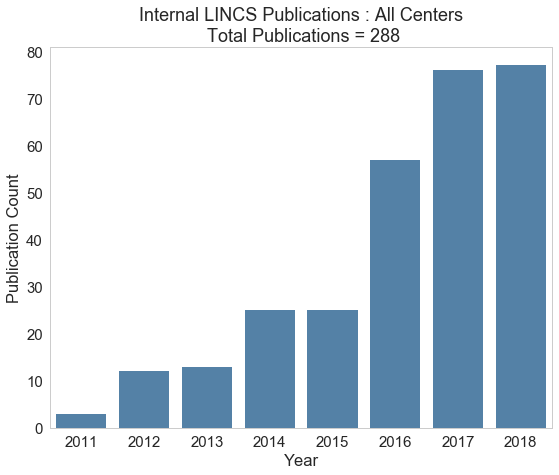

In [323]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 

sn.countplot( data_internal['YEAR'], color='steelblue') 
plt.title('Internal LINCS Publications : All Centers\n Total Publications = '+
          str(len( data_internal )))
plt.xlabel('Year')
plt.ylabel('Publication Count')
plt.show();
# plt.ylim(0,50);

### Separated By Center

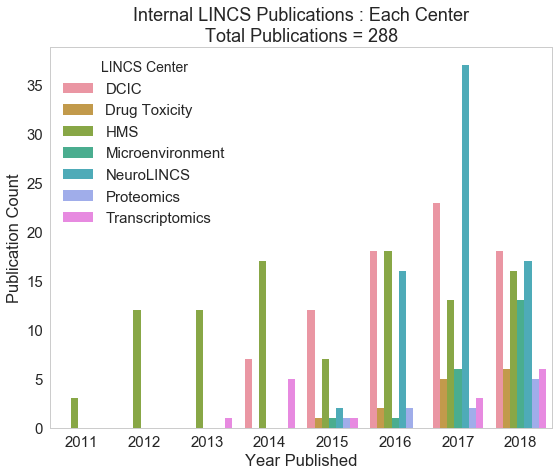

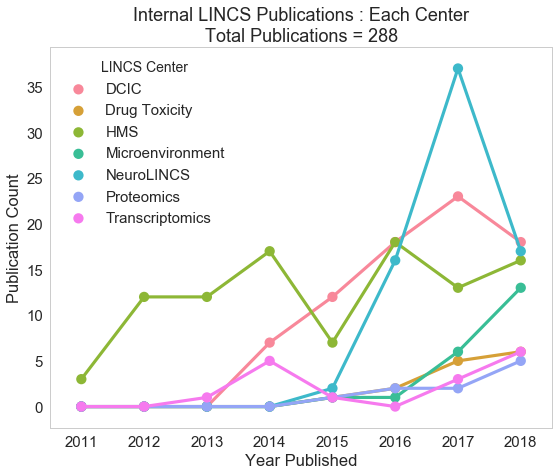

In [345]:
plt.figure(figsize=(9,7) ) # Default 8,6 #, dpi=100

internalByCenter = {}
for center in Centers: 
    internalByCenter[center] = data_internal.groupby('YEAR')[center].sum()
    
internalByCenter = pd.DataFrame(internalByCenter).stack().reset_index()
internalByCenter.columns = ['YEAR', 'LINCS Center', 'Count']
internalByCenter['YEAR'] = internalByCenter['YEAR'].astype(int)


# internalByCenter = internalByCenter[internalByCenter['YEAR']>=1]

sn.barplot(data=internalByCenter, x='YEAR',y='Count',hue='LINCS Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( data_internal ) ) )
plt.xlabel('Year Published')
plt.ylabel('Publication Count');
# plt.ylim(0,10);

# Line plot
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
sn.pointplot(data=internalByCenter, x='YEAR',y='Count',hue='LINCS Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( data_internal ) ) )
plt.xlabel('Year Published')
plt.ylabel('Publication Count');


## Internal LINCS CITATIONS

### Aggregated Across Centers

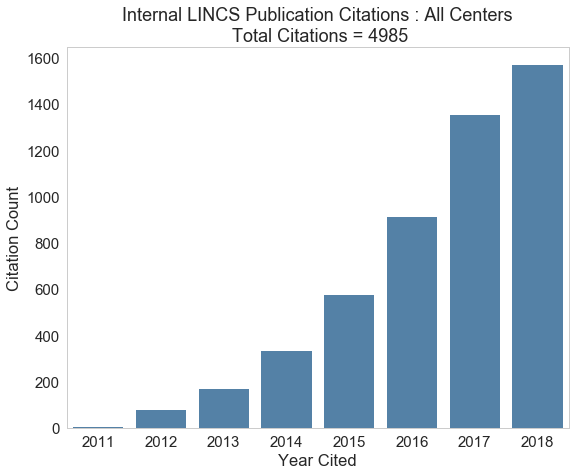

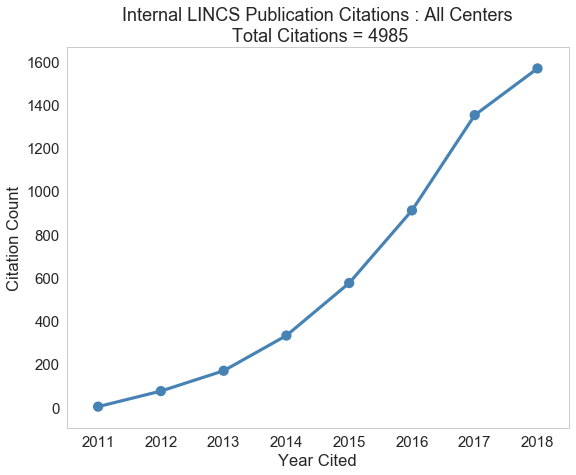

In [346]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  

data_internal['YEAR'] = data_internal['YEAR'].astype(str)
from collections import Counter 
centerCounter={}     
for center in Centers:
    sub = internal.loc[internal[center]==1]
    yearCounter={}
    counter=Counter()
    for i,row in sub.iterrows(): 
        try:
            counter += Counter( row['citation_years'] )  
        except:
            counter += Counter()
    centerCounter[center]=counter
    
centerCounter = pd.DataFrame(centerCounter).fillna(0).stack().reset_index() 
centerCounter.rename(columns={'level_0':'year_cited','level_1':'LINCS Center',0:'Count'}, inplace=True)
 
yearCounter_sum = centerCounter.groupby(['year_cited'])['Count'].sum().reset_index()
# yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0].loc[yearCounter_sum['year_cited']!=2018] 
yearCounter_sum['year_cited'] = yearCounter_sum['year_cited'].replace({0:2018})
yearCounter_sum = yearCounter_sum.groupby('year_cited').sum().reset_index()
# missingYears = set(range(2011,2018+1)) - set(yearCounter_sum['year_cited'])  

    
sn.barplot(data=yearCounter_sum, x='year_cited', y='Count', color='steelblue')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['Count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count')


# Line plot
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
sn.pointplot(data=yearCounter_sum, x='year_cited', y='Count', color='steelblue')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['Count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
 

### Separated By Center

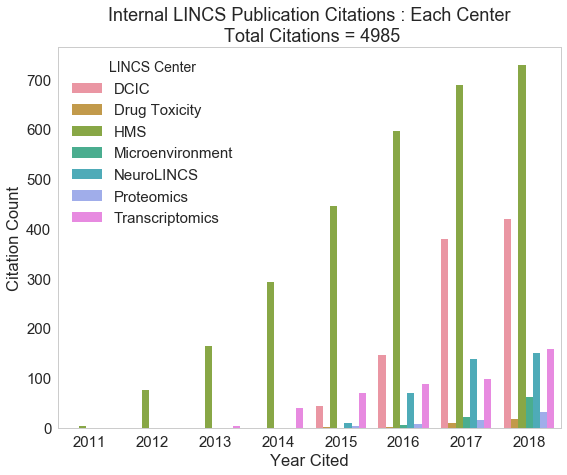

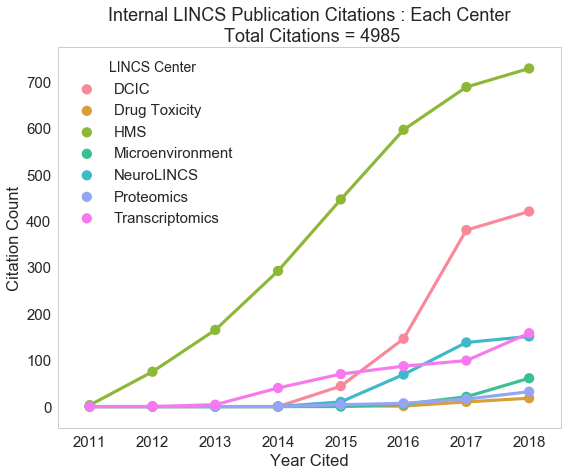

In [347]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 

yearCounter_sum = centerCounter.groupby(['year_cited','LINCS Center'])['Count'].sum().reset_index()
# yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0].loc[yearCounter_sum['year_cited']!=2018]
yearCounter_sum['year_cited'] = yearCounter_sum['year_cited'].replace({0:2018})
yearCounter_sum = yearCounter_sum.groupby(['year_cited','LINCS Center']).sum().reset_index()

sn.barplot(data=yearCounter_sum, x='year_cited', y='Count', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : Each Center\n Total Citations = '+\
          str( int(sum(yearCounter_sum['Count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count');

# Line plot
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 
sn.pointplot(data=yearCounter_sum, x='year_cited', y='Count', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : Each Center\n Total Citations = '+\
          str( int(sum(yearCounter_sum['Count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count');




#### Report Publications & Citations by Center

In [351]:
# Pubs
internalByCenter_pubs = internalByCenter.groupby('LINCS Center')['Count'].sum().reset_index()
# Citspublicat
internalByCenter_cits = yearCounter_sum.groupby('LINCS Center')['Count'].sum().astype(int).reset_index()

internalByCenter_summary = internalByCenter_pubs.merge(internalByCenter_cits, on='LINCS Center') 
internalByCenter_summary.columns = ['LINCS Center', 'Publications', 'Citations'] 
Total = internalByCenter_summary.sum()
Total.iloc[0] = 'TOTAL'


internalByCenter_summary = internalByCenter_summary.append(Total, ignore_index=True)


internalByCenter_summary.to_csv('internalByCenter_summary.csv', index=False)
display(internalByCenter_summary)

,LINCS Center,Publications,Citations
0,DCIC,78,990
1,Drug Toxicity,14,30
2,HMS,98,2993
3,Microenvironment,21,87
4,NeuroLINCS,72,368
5,Proteomics,10,59
6,Transcriptomics,16,458
7,TOTAL,309,4985


## External LINCS Publications

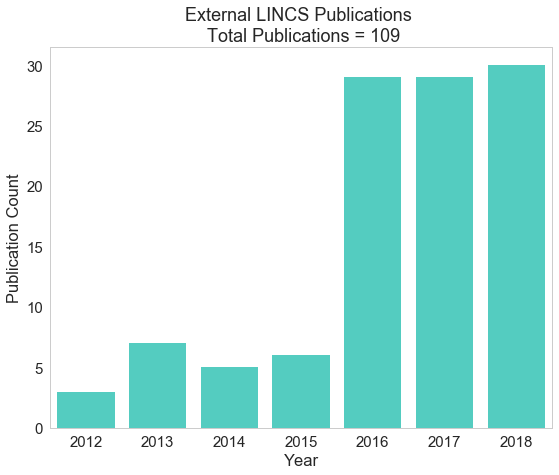

In [328]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 

sn.countplot( data_external['YEAR'], color='turquoise')
plt.title('External LINCS Publications \n Total Publications = '+
          str(len( data_external )))
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

## External LINCS Citations

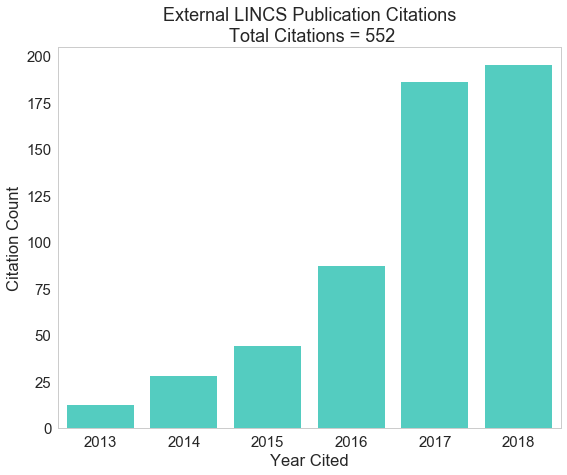

In [329]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
data_external['YEAR'] = data_external['YEAR'].astype(str)

from collections import Counter   
yearCounter=Counter()
for i,row in external.iterrows(): 
    try:
        yearCounter += Counter( row['citation_years'] )  
    except:
        yearCounter += Counter() 
    
yearCounter = pd.DataFrame(pd.Series(yearCounter)).reset_index()
yearCounter.rename(columns={'index':'year_cited',0:'count'}, inplace=True)
### ** Additional filter to exclude years == 0 or 2018
# yearCounter = yearCounter[yearCounter['year_cited']!=0].loc[yearCounter['year_cited']!=2018]
yearCounter['year_cited'] = yearCounter['year_cited'].replace({0:2018})
yearCounter = yearCounter.groupby(['year_cited']).sum().reset_index()

sn.barplot(data=yearCounter, x='year_cited', y='count', color='turquoise')
plt.title('External LINCS Publication Citations\n Total Citations = '+\
          str( int(sum(yearCounter['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
 

## Combined Bar Plot Aggregated Across Years

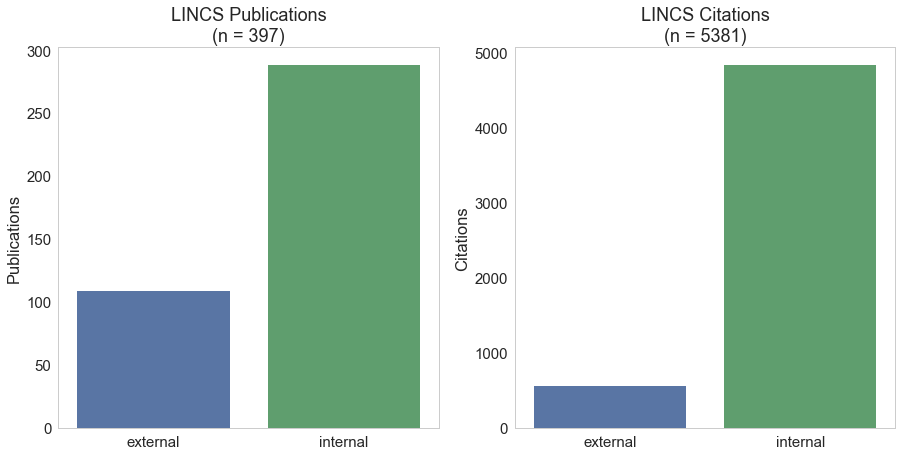

In [330]:
fig, ax = plt.subplots(figsize=(15,7))
# import matplotlib.pyplot as plt

data['pm_id'] = data['pm_id'].fillna(0000000)
bar_pubs = data.groupby('InternalExternal')['pm_id'].count().reset_index()
bar_cits = data.groupby('InternalExternal')['n_citations'].sum().reset_index()

bar_data = bar_pubs.merge(bar_cits, on='InternalExternal') 
bar_data.index = bar_data['InternalExternal']
bar_data = bar_data.iloc[:,1:].stack().reset_index().rename(columns={'level_1':'Metric', 0:'Count'}) 
bar_data['Metric'] = bar_data['Metric'].replace({'pm_id':'Publications','n_citations':'Citations'})
  
 
# fig, ax = plt.subplots(figsize=(10,7))
plt.subplot(1, 2, 1)


data['pm_id'] = data['pm_id'].fillna(0000000)
bar_pubs = data.groupby('InternalExternal')['pm_id'].count().reset_index()
bar_cits = data.groupby('InternalExternal')['n_citations'].sum().reset_index()

bar_data = bar_pubs.merge(bar_cits, on='InternalExternal') 
bar_data.index = bar_data['InternalExternal']
bar_data = bar_data.iloc[:,1:].stack().reset_index().rename(columns={'level_1':'Metric', 0:'Count'}) 
bar_data['Metric'] = bar_data['Metric'].replace({'pm_id':'Publications','n_citations':'Citations'})

 

g1 = sn.barplot(data=bar_pubs, x='InternalExternal', y='pm_id' )
plt.xlabel('')
plt.ylabel('Publications')

plt.title('LINCS Publications\n(n = '+  str(len( data )) +')') ;


# ax2 = plt.twinx() # Multiple y axes
# fig, ax = plt.subplots(figsize=(10,7))
plt.subplot(1, 2, 2)

g2 = sn.barplot(data=bar_cits, x='InternalExternal', y='n_citations' )
plt.xlabel('')
plt.ylabel('Citations')

plt.title('LINCS Citations\n(n = '+str(int( data['n_citations'].sum())) +')') ;
#  
# plt.title('LINCS Publications & Citations\nPublications = '+
#           str(len( data ))+' , Citations = '+str(int( data['n_citations'].sum())) ) 
 
 

"""
fig, ax1 = plt.subplots(figsize=(10,7))
sn.barplot(data=bar_data, x='Metric', y='Count', hue='InternalExternal', ax=ax1)
ax1.set_ylabel('Publications')
maxPublication = bar_data.loc[bar_data['Metric']=='Publications']['Count'].max()
# ax1.set_ylim( (0, int(maxPublication)) )

ax2 = ax1.twinx()
maxCitation = bar_data.loc[bar_data['Metric']=='Citations']['Count'].max()
ax2.set_ylim( (0, int(maxCitation)) )
# ax2.set_yticklabels( np.round(ax1.get_yticks() ,1) )
ax2.set_ylabel('Citations')
""";
 


## Cumulative Plots

### Internal/External Combined

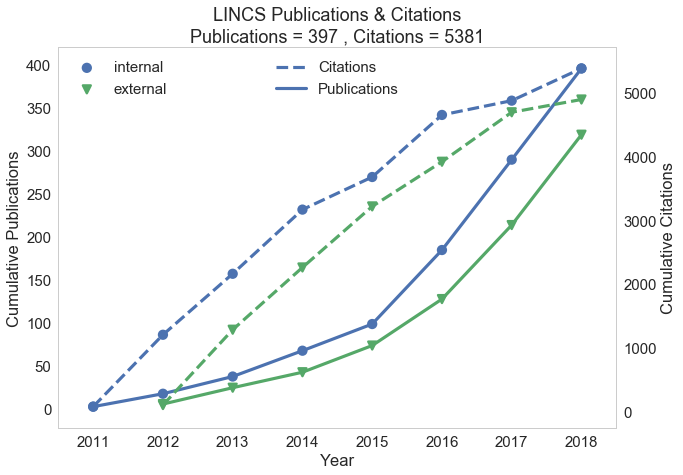

In [331]:
# plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
fig, ax = plt.subplots(figsize=(10,7))
sn.set_style("whitegrid", {'axes.grid' : False})


# Plot publications
g1 = sn.pointplot(data=grouped_pubs, x='YEAR', y='cumul_publications', hue='InternalExternal',linestyles=["-", "-"],markers=['o','v'])
h1 = plt.gca().get_label()
lg1 = plt.legend(title='', handles=h1, labels=['Internal','External'], loc='upper left')

plt.xlabel('Year')
plt.ylabel('Cumulative Publications')
# Plot citations
ax2 = plt.twinx() # Multiple y axes
g2 = sn.pointplot(data=grouped_cits, x='YEAR', y='cumul_citations', hue='InternalExternal', linestyles=["--", "--"],markers=['o','v'])
plt.xlabel('Year')
plt.ylabel('Cumulative Citations')
## Custom legend
h2 = plt.gca().get_lines()
lg2 = plt.legend(handles=h2, labels=['Citations','Publications'], loc='upper center' )


plt.title('LINCS Publications & Citations\nPublications = '+
          str(len( data ))+' , Citations = '+str(int( data['n_citations'].sum())) );


### Publications Only

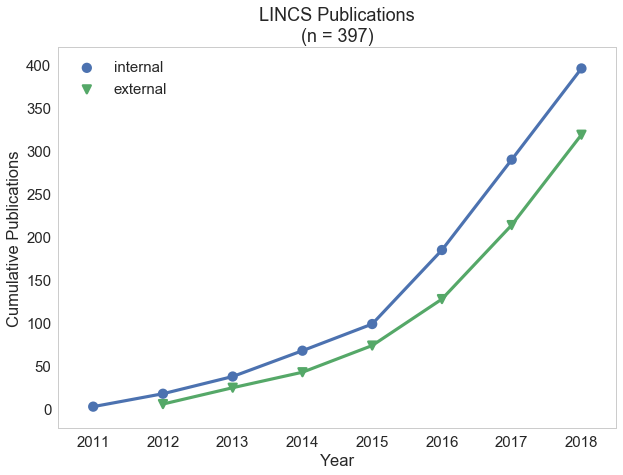

In [332]:
fig, ax = plt.subplots(figsize=(10,7))
   
# grouped_pubs_int = grouped_pubs.loc[grouped_pubs['InternalExternal']=='internal',:]

# Plot publications
g1 = sn.pointplot(data=grouped_pubs, x='YEAR', y='cumul_publications', hue='InternalExternal',linestyles=["-", "-"],markers=['o','v'])
plt.xlabel('Year')
plt.ylabel('Cumulative Publications')
# remove legend
# ax.legend_.remove()
h1 = plt.gca().get_label()
lg1 = plt.legend(title='', handles=h1, labels=['Internal','External'], loc='upper left')


plt.title('LINCS Publications\n(n = '+ str( len(data) ) +')') ;

**Figure 1** : PubMed IDs (PMIDs) of publications produced by LINCS centers (internal) were extracted by querying the PubMed Central API for all publications that listed LINCS funding sources (9 different NIH grants awarded to 7 different LINCS centers). The above plot shows the cumulative count of LINCS publications over time, for only the internal LINCS publications.

### Citations Only

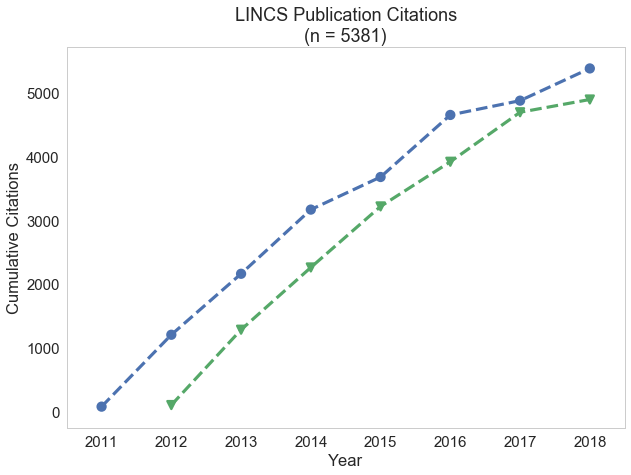

In [333]:
fig, ax = plt.subplots(figsize=(10,7)) 

# grouped_cits_int = grouped_cits.loc[grouped_cits['InternalExternal']=='internal',:]

# Plot publications
g1 = sn.pointplot(data=grouped_cits, x='YEAR', y='cumul_citations', hue='InternalExternal',linestyles=["--", "--"],markers=['o','v'])
plt.xlabel('Year')
plt.ylabel('Cumulative Citations')
# remove legend
ax.legend_.remove()

plt.title('LINCS Publication Citations\n(n = '+ str(int(sum(grouped_cits['n_citations']))) +')') ;

**Figure 2** : PMIDs of each LINCS publication were converted to PubMed Central IDs (PMCIDs). These PMCIDs were submitted to another PubMed Central API which extracted the PMIDs of papers that cited each internal/external publication and the year that they were cited. The above plot shows the cumulative count of LINCS publication citations over time, for only the internal LINCS publications.